In [ ]:
# The code below was helped by AI-[1]
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
# Work in Colab's local scratch space
%cd /content

# Fresh clone of your class repo
!rm -rf coe379l-fa25
!git clone --depth 1 https://github.com/joestubbs/coe379l-fa25.git

# Look at the unit03 folder to confirm structure
!ls -la /content/coe379l-fa25/datasets
!ls -la /content/coe379l-fa25/datasets/unit03
!ls -la /content/coe379l-fa25/datasets/unit03/Project2
from pathlib import Path
import os
import tensorflow as tf

# HARD-CODED dataset path (no f-strings, no reused vars)
DATA_ROOT = Path("/content/coe379l-fa25/datasets/unit03/Project2")

print("DATA_ROOT exists?:", DATA_ROOT.exists())
print("damage dir exists?:", (DATA_ROOT / "damage").exists())
print("no_damage dir exists?:", (DATA_ROOT / "no_damage").exists())

# Quick sanity check on file counts
# The code below was helped by AI-[2]
n_damage = len(os.listdir(DATA_ROOT / "damage"))
n_nodmg  = len(os.listdir(DATA_ROOT / "no_damage"))
print(f"Files -> damage: {n_damage} | no_damage: {n_nodmg}")

# Make sure we can load a batch with tf.data
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32

ds = tf.keras.utils.image_dataset_from_directory(
    str(DATA_ROOT),        # use string path to be extra safe
    labels="inferred",
    label_mode="binary",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

print("Class names discovered:", ds.class_names)

for images, labels in ds.take(1):
    print("Sample batch images shape:", images.shape)
    print("Sample batch labels shape:", labels.shape)
    break


TensorFlow version: 2.19.0
/content
Cloning into 'coe379l-fa25'...
remote: Enumerating objects: 21490, done.
remote: Counting objects: 100% (21490/21490), done.
remote: Compressing objects: 100% (21485/21485), done.
remote: Total 21490 (delta 3), reused 21450 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (21490/21490), 76.44 MiB | 31.36 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (21480/21480), done.
total 20
drwxr-xr-x 5 root root 4096 Nov 15 21:53 .
drwxr-xr-x 7 root root 4096 Nov 15 21:53 ..
drwxr-xr-x 2 root root 4096 Nov 15 21:53 unit01
drwxr-xr-x 2 root root 4096 Nov 15 21:53 unit02
drwxr-xr-x 3 root root 4096 Nov 15 21:53 unit03
total 12
drwxr-xr-x 3 root root 4096 Nov 15 21:53 .
drwxr-xr-x 5 root root 4096 Nov 15 21:53 ..
drwxr-xr-x 4 root root 4096 Nov 15 21:53 Project2
total 1240
drwxr-xr-x 4 root root   4096 Nov 15 21:53 .
drwxr-xr-x 3 root root   4096 Nov 15 21:53 ..
drwxr-xr-x 2 root root 839680 Nov 15 21:53 damage
drwxr-xr-x 2 root ro

In [ ]:
# Part 1: Imports and global configuration
# The code below was helped by AI-[3]

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

# Path to your dataset in the cloned repo
DATA_ROOT = Path("/content/coe379l-fa25/datasets/unit03/Project2")

# Sanity check: make sure the directories exist
assert DATA_ROOT.exists(), f"DATA_ROOT does not exist: {DATA_ROOT}"
assert (DATA_ROOT / "damage").exists(), "Missing 'damage' folder"
assert (DATA_ROOT / "no_damage").exists(), "Missing 'no_damage' folder"

# Image and training parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

BATCH_SIZE = 32
EPOCHS = 4

AUTOTUNE = tf.data.AUTOTUNE


TensorFlow version: 2.19.0


In [ ]:
# Explore the raw dataset
# The code below was helped by AI-[4]
def count_images_per_class(root: Path):
    """Count how many images there are in each class directory."""
    counts = {}
    for name in sorted(os.listdir(root)):
        subdir = root / name
        if subdir.is_dir():
            num_files = len([f for f in subdir.iterdir() if f.is_file()])
            counts[name] = num_files
    return counts

counts = count_images_per_class(DATA_ROOT)

print("Image counts per class in DATA_ROOT:")
total_images = 0
for cls, num in counts.items():
    print(f"  {cls}: {num}")
    total_images += num
print("Total images:", total_images)


Image counts per class in DATA_ROOT:
  damage: 14170
  no_damage: 7152
Total images: 21322


In [ ]:
#Build train, validation, and test datasets
# The code below was helped by AI-[5]

def make_splits(root: Path):
    """
    Create three tf.data.Dataset objects:
      - train_ds: ~80% of the data
      - val_ds:   ~10% of the data
      - test_ds:  ~10% of the data

    We first let Keras create an 80/20 split, then split the 20% in half.
    """
    # 1) 80% training
    train_ds = tf.keras.utils.image_dataset_from_directory(
        root,
        labels="inferred",
        label_mode="binary",          # labels are 0.0 or 1.0
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=0.2,
        subset="training",
        seed=42,
    )

    # 2) 20% that we'll later divide into val/test
    valtest_ds = tf.keras.utils.image_dataset_from_directory(
        root,
        labels="inferred",
        label_mode="binary",
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=0.2,
        subset="validation",
        seed=42,
    )

    print("Original class order from directory:", train_ds.class_names)

    class_names = train_ds.class_names
    assert set(class_names) == {"damage", "no_damage"}, "Unexpected class names."

    # We want label 1.0 = 'damage', 0.0 = 'no_damage'.
    # By default, labels correspond to indices in class_names (sorted alphabetically).
    damage_index = class_names.index("damage")

    def remap_labels(images, labels):
        """
        Map labels so that:
          label == 1.0 -> damage
          label == 0.0 -> no_damage
        """
        if damage_index == 0:
            # class_names is ['damage', 'no_damage'] -> 0 = damage, 1 = no_damage
            # invert labels so damage -> 1.0, no_damage -> 0.0
            labels = 1.0 - labels
        else:
            # already in the desired format
            labels = tf.identity(labels)
        return images, labels

    train_ds = train_ds.map(remap_labels)
    valtest_ds = valtest_ds.map(remap_labels)

    # 3) Split valtest_ds into validation and test (50/50)
    #    We use cardinality (number of batches) to do this.
    valtest_batches = valtest_ds.cardinality().numpy()
    if valtest_batches < 0:
        raise ValueError("Unknown dataset cardinality; cannot split val/test cleanly.")
    val_batches = valtest_batches // 2

    val_ds = valtest_ds.take(val_batches)
    test_ds = valtest_ds.skip(val_batches)

    # 4) Add caching and prefetching for performance
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds   = val_ds.cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.cache().prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

train_ds, val_ds, test_ds, class_names = make_splits(DATA_ROOT)
print("Datasets ready: train, val, test.")


Found 21322 files belonging to 2 classes.
Using 17058 files for training.
Found 21322 files belonging to 2 classes.
Using 4264 files for validation.
Original class order from directory: ['damage', 'no_damage']
Datasets ready: train, val, test.


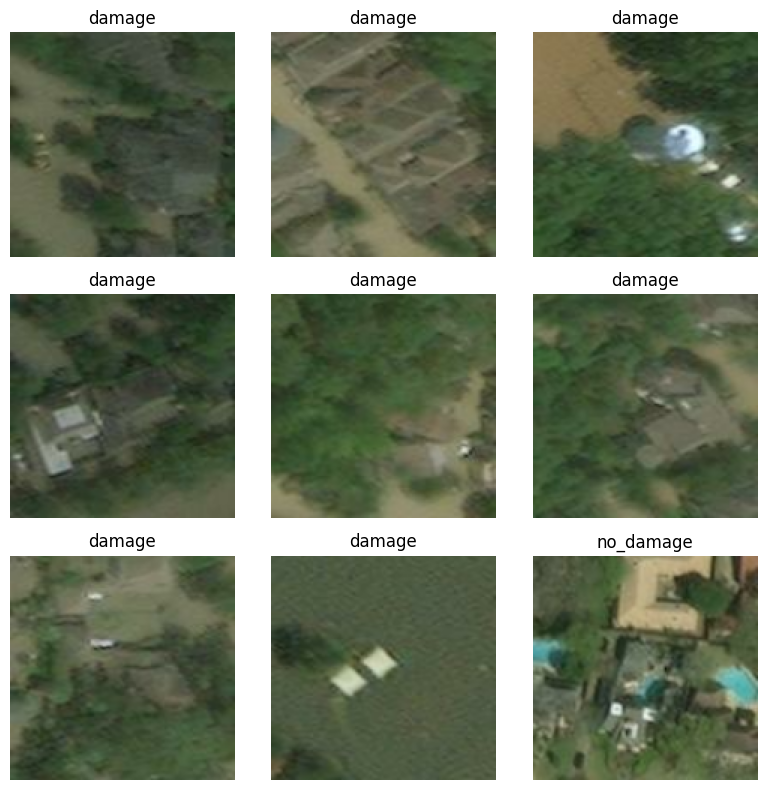

In [ ]:
#Visualize some example images
# The code below was helped by AI-[6]

def show_example_images(dataset, num_images=9):
    """Show a grid of example images with their labels."""
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        count = min(num_images, images.shape[0])
        for i in range(count):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # labels are 0.0 (no_damage) or 1.0 (damage)
            label_val = labels[i].numpy()
            label_str = "damage" if label_val >= 0.5 else "no_damage"
            plt.title(label_str)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

show_example_images(train_ds, num_images=9)


In [ ]:
#Part 2: Define model architectures (fixed pooling layers)
# The code below was helped by AI-[7]
def build_dense_model(input_shape):
    """
    Fully connected (dense) neural network.
    - Flattens the image
    - 2 hidden layers
    - Final sigmoid neuron for binary classification
    """
    model = keras.Sequential(
        [
            layers.Input(shape=input_shape),
            # Normalize pixel values from [0, 255] to [0, 1]
            layers.Rescaling(1.0 / 255.0),

            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.5),

            layers.Dense(1, activation="sigmoid"),  # output = P(damage)
        ],
        name="dense_ann",
    )
    return model


def build_lenet5_model(input_shape):
    """
    LeNet-5 style CNN adapted to 150x150x3 images.
    Original LeNet-5 had:
      Conv -> AvgPool -> Conv -> AvgPool -> FC -> FC -> Output
    We follow the same pattern with modern Keras layers.
    """
    model = keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1.0 / 255.0),

            layers.Conv2D(6, (5, 5), activation="relu", padding="valid"),
            layers.AveragePooling2D(pool_size=(2, 2)),

            layers.Conv2D(16, (5, 5), activation="relu", padding="valid"),
            layers.AveragePooling2D(pool_size=(2, 2)),

            layers.Flatten(),
            layers.Dense(120, activation="relu"),
            layers.Dense(84, activation="relu"),

            layers.Dense(1, activation="sigmoid"),
        ],
        name="lenet5",
    )
    return model


def build_alt_lenet5_model(input_shape):
    """
    Alternate-LeNet-5 CNN (based on the paper in your project description).
    Conv/Pool stack:
      Conv(32,3x3) -> MaxPool(2x2)
      Conv(64,3x3) -> MaxPool(2x2)
      Conv(128,3x3)-> MaxPool(2x2)
      Conv(128,3x3)-> MaxPool(2x2)
    Then Flatten -> Dropout -> Dense(512) -> Output.
    """
    model = keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1.0 / 255.0),

            layers.Conv2D(32, (3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(512, activation="relu"),

            layers.Dense(1, activation="sigmoid"),
        ],
        name="alt_lenet5",
    )
    return model


In [ ]:
#Helper function to compile, train, and evaluate models
# The code below was helped by AI-[8]

def compile_and_train(model, train_ds, val_ds, model_name, epochs=EPOCHS):
    """
    Compile a model, train it, evaluate on validation set, and return metrics.
    """
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=3,
                restore_best_weights=True,
            )
        ],
    )

    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    print(f"{model_name}: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    return model, history, float(val_loss), float(val_acc)


In [ ]:
#Train all three models, pick best, evaluate on test, and save
# The code below was helped by AI-[9]


import os, json

results = []

#Train Dense ANN
dense_model, dense_hist, dense_vloss, dense_vacc = compile_and_train(
    build_dense_model(INPUT_SHAPE),
    train_ds,
    val_ds,
    model_name="dense_ann",
    epochs=EPOCHS,
)
results.append(("dense_ann", dense_model, dense_vloss, dense_vacc))

#Train LeNet-5
lenet_model, lenet_hist, lenet_vloss, lenet_vacc = compile_and_train(
    build_lenet5_model(INPUT_SHAPE),
    train_ds,
    val_ds,
    model_name="lenet5",
    epochs=EPOCHS,
)
results.append(("lenet5", lenet_model, lenet_vloss, lenet_vacc))

#Train Alternate-LeNet-5
alt_model, alt_hist, alt_vloss, alt_vacc = compile_and_train(
    build_alt_lenet5_model(INPUT_SHAPE),
    train_ds,
    val_ds,
    model_name="alt_lenet5",
    epochs=EPOCHS,
)
results.append(("alt_lenet5", alt_model, alt_vloss, alt_vacc))

#Print validation results for all three
print("\nValidation results:")
for name, model, vloss, vacc in results:
    print(f"  {name}: val_loss={vloss:.4f}, val_acc={vacc:.4f}")

#Select best model by highest validation accuracy
best_name, best_model, best_vloss, best_vacc = max(results, key=lambda x: x[3])
print(f"\nBest model on validation: {best_name} (val_acc = {best_vacc:.4f})")

#Evaluate best model on the held-out test set
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"{best_name} on test set -> loss={test_loss:.4f}, acc={test_acc:.4f}")


os.makedirs("models", exist_ok=True)
best_model_path = "models/best_model.keras"
best_model.save(best_model_path)

metadata = {
    "image_size": [IMG_HEIGHT, IMG_WIDTH],
    "channels": CHANNELS,
    "class_names": class_names,
    "label_encoding": "1 = damage, 0 = no_damage",
    "best_model": {
        "name": best_name,
        "val_loss": float(best_vloss),
        "val_acc": float(best_vacc),
        "file": best_model_path,
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
    },
}

with open("models/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("\nSaved files:")
print("  -", best_model_path)
print("  - models/metadata.json")


Epoch 1/4
534/534 ━━━━━━━━━━━━━━━━━━━━ 98s 181ms/step - accuracy: 0.6455 - loss: 2.1339 - val_accuracy: 0.6544 - val_loss: 0.6449
Epoch 2/4
534/534 ━━━━━━━━━━━━━━━━━━━━ 133s 164ms/step - accuracy: 0.6641 - loss: 0.6460 - val_accuracy: 0.6544 - val_loss: 0.6450
Epoch 3/4
534/534 ━━━━━━━━━━━━━━━━━━━━ 88s 165ms/step - accuracy: 0.6654 - loss: 0.6388 - val_accuracy: 0.6544 - val_loss: 0.6450
Epoch 4/4
534/534 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.6654 - loss: 0.6380 - val_accuracy: 0.6544 - val_loss: 0.6451
dense_ann: val_loss=0.6449, val_acc=0.6544
Epoch 1/4
534/534 ━━━━━━━━━━━━━━━━━━━━ 317s 590ms/step - accuracy: 0.7482 - loss: 0.5338 - val_accuracy: 0.8843 - val_loss: 0.2820
Epoch 2/4
534/534 ━━━━━━━━━━━━━━━━━━━━ 321s 589ms/step - accuracy: 0.8752 - loss: 0.2960 - val_accuracy: 0.8769 - val_loss: 0.3143
Epoch 3/4
534/534 ━━━━━━━━━━━━━━━━━━━━ 323s 591ms/step - accuracy: 0.8945 - loss: 0.2542 - val_accuracy: 0.8871 - val_loss: 0.3113
Epoch 4/4
534/534 ━━━━━━━━━━━━━━━━━━━━ 315

In [ ]:
import os

print("Current dir:", os.getcwd())
print("Contents:", os.listdir())

if os.path.isdir("models"):
    print("models/", os.listdir("models"))
else:
    print("No 'models' directory yet.")


Current dir: /content
Contents: ['.config', 'coe379l-fa25', 'models', 'sample_data']
models/ ['best_model.keras', 'metadata.json']


In [ ]:
from google.colab import files

files.download("models/best_model.keras")
files.download("models/metadata.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>